<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [2]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 10000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 10000


In [4]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [5]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

In [6]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 4948
Sentencia de entrada más larga: 32


In [7]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 7731
Sentencia de salida más larga: 36


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [8]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 50
max_out_len = 50

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [9]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 10000
encoder_input_sequences shape: (10000, 50)
decoder_input_sequences shape: (10000, 50)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [10]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(10000, 50, 7732)

### 3 - Preparar los embeddings

In [11]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [12]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2430  100  2430    0     0   3197      0 --:--:-- --:--:-- --:--:--  3197


In [13]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [14]:
!rm -f gloveembedding.pkl
import gdown

url = "https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94"
output = "gloveembedding.pkl"

gdown.download(url, output, use_cookies=True, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&confirm=t&uuid=8944b32c-606b-4cb4-81ff-d458be6302a6
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:11<00:00, 45.9MB/s]


'gloveembedding.pkl'

In [15]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [16]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 47


In [17]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(4948, 50)

### 4 - Entrenar el modelo

In [18]:
max_input_len

50

Para la última prueba se empleó esta función que permite

In [19]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
n_units = 256

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# encoder_embedding_layer = Embedding(
#           input_dim=nb_words,  # definido en el Tokenizador
#           output_dim=embed_dim,  # dimensión de los embeddings utilizados
#           input_length=max_input_len, # tamaño máximo de la secuencia de entrada
#           weights=[embedding_matrix],  # matrix de embeddings
#           trainable=True)      # marcar como layer no entrenable

# encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# encoder = LSTM(n_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
# encoder_states = [state_h, state_c]

## --------------------------------------------------------------
## PARA UNA DE LAS PRUEBAS SE MODIFIFO LA ESTRUCTURA DEL ENCODER

# # Primera capa LSTM, retorna secuencias para la segunda capa
# encoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
# encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs_x)

# # Segunda capa LSTM
# encoder_lstm2 = LSTM(n_units, return_state=True)
# encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# # Estados finales del encoder
# encoder_states = [state_h2, state_c2]

## ---------------------------------------------------------------

# Entrada del encoder
encoder_inputs = Input(shape=(max_input_len,))

# Capa de embedding usando Glove preentrenado
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    weights=[embedding_matrix],
    input_length=max_input_len,
    trainable=False
)

# Secuencia de embeddings
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# LSTM del encoder
encoder = LSTM(n_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)

encoder_states = [state_h, state_c]


# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 50)    │    247,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 256)   │  1,979,392 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    314,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 7732)  │  1,987,124 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,053,596 (19.28 MB)

 Trainable params: 4,806,196 (18.33 MB)

 Non-trainable params: 247,400 (966.41 KB)

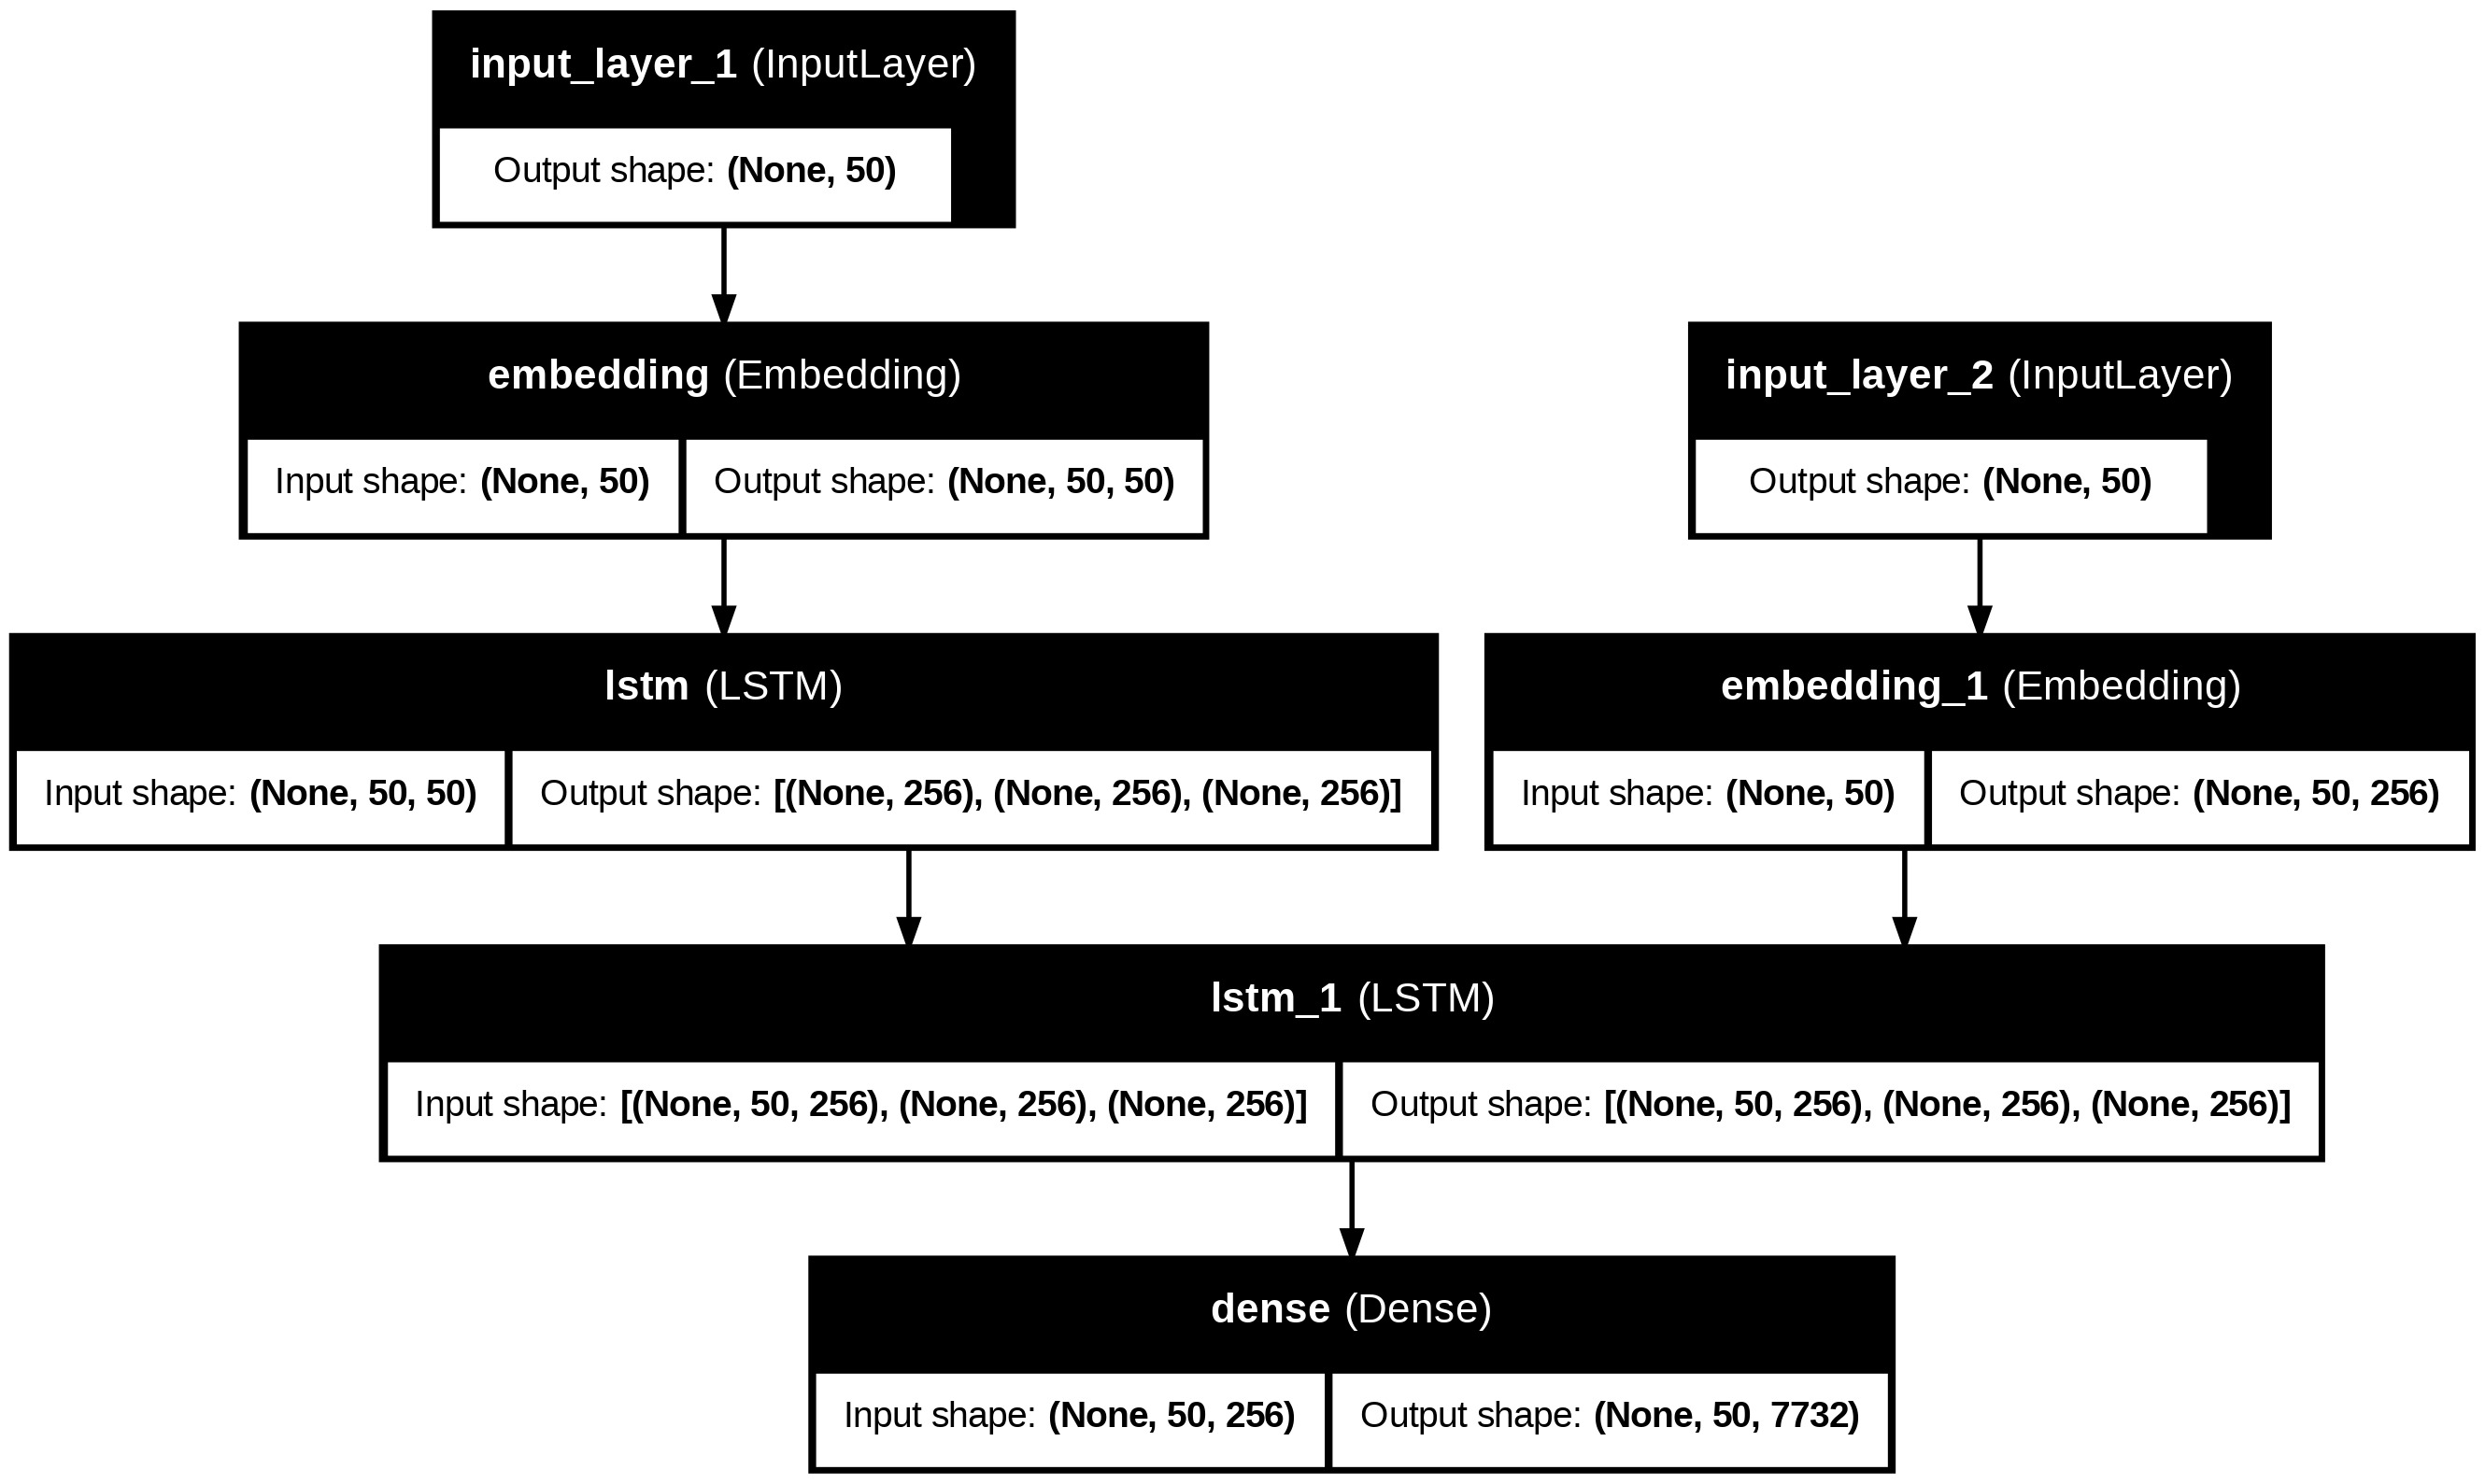

In [20]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

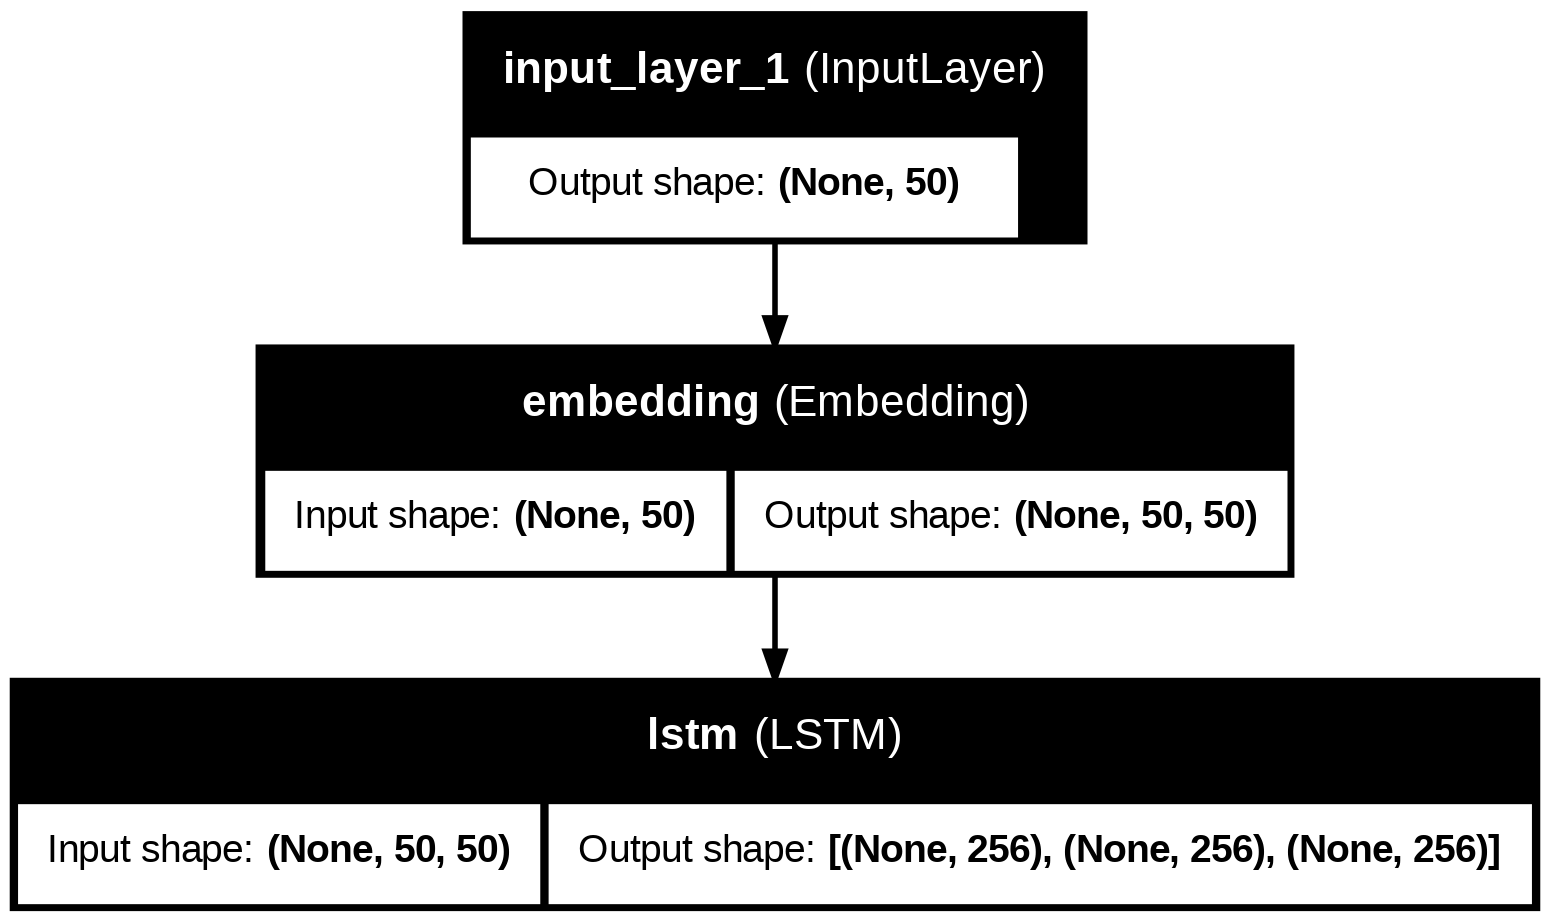

In [21]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

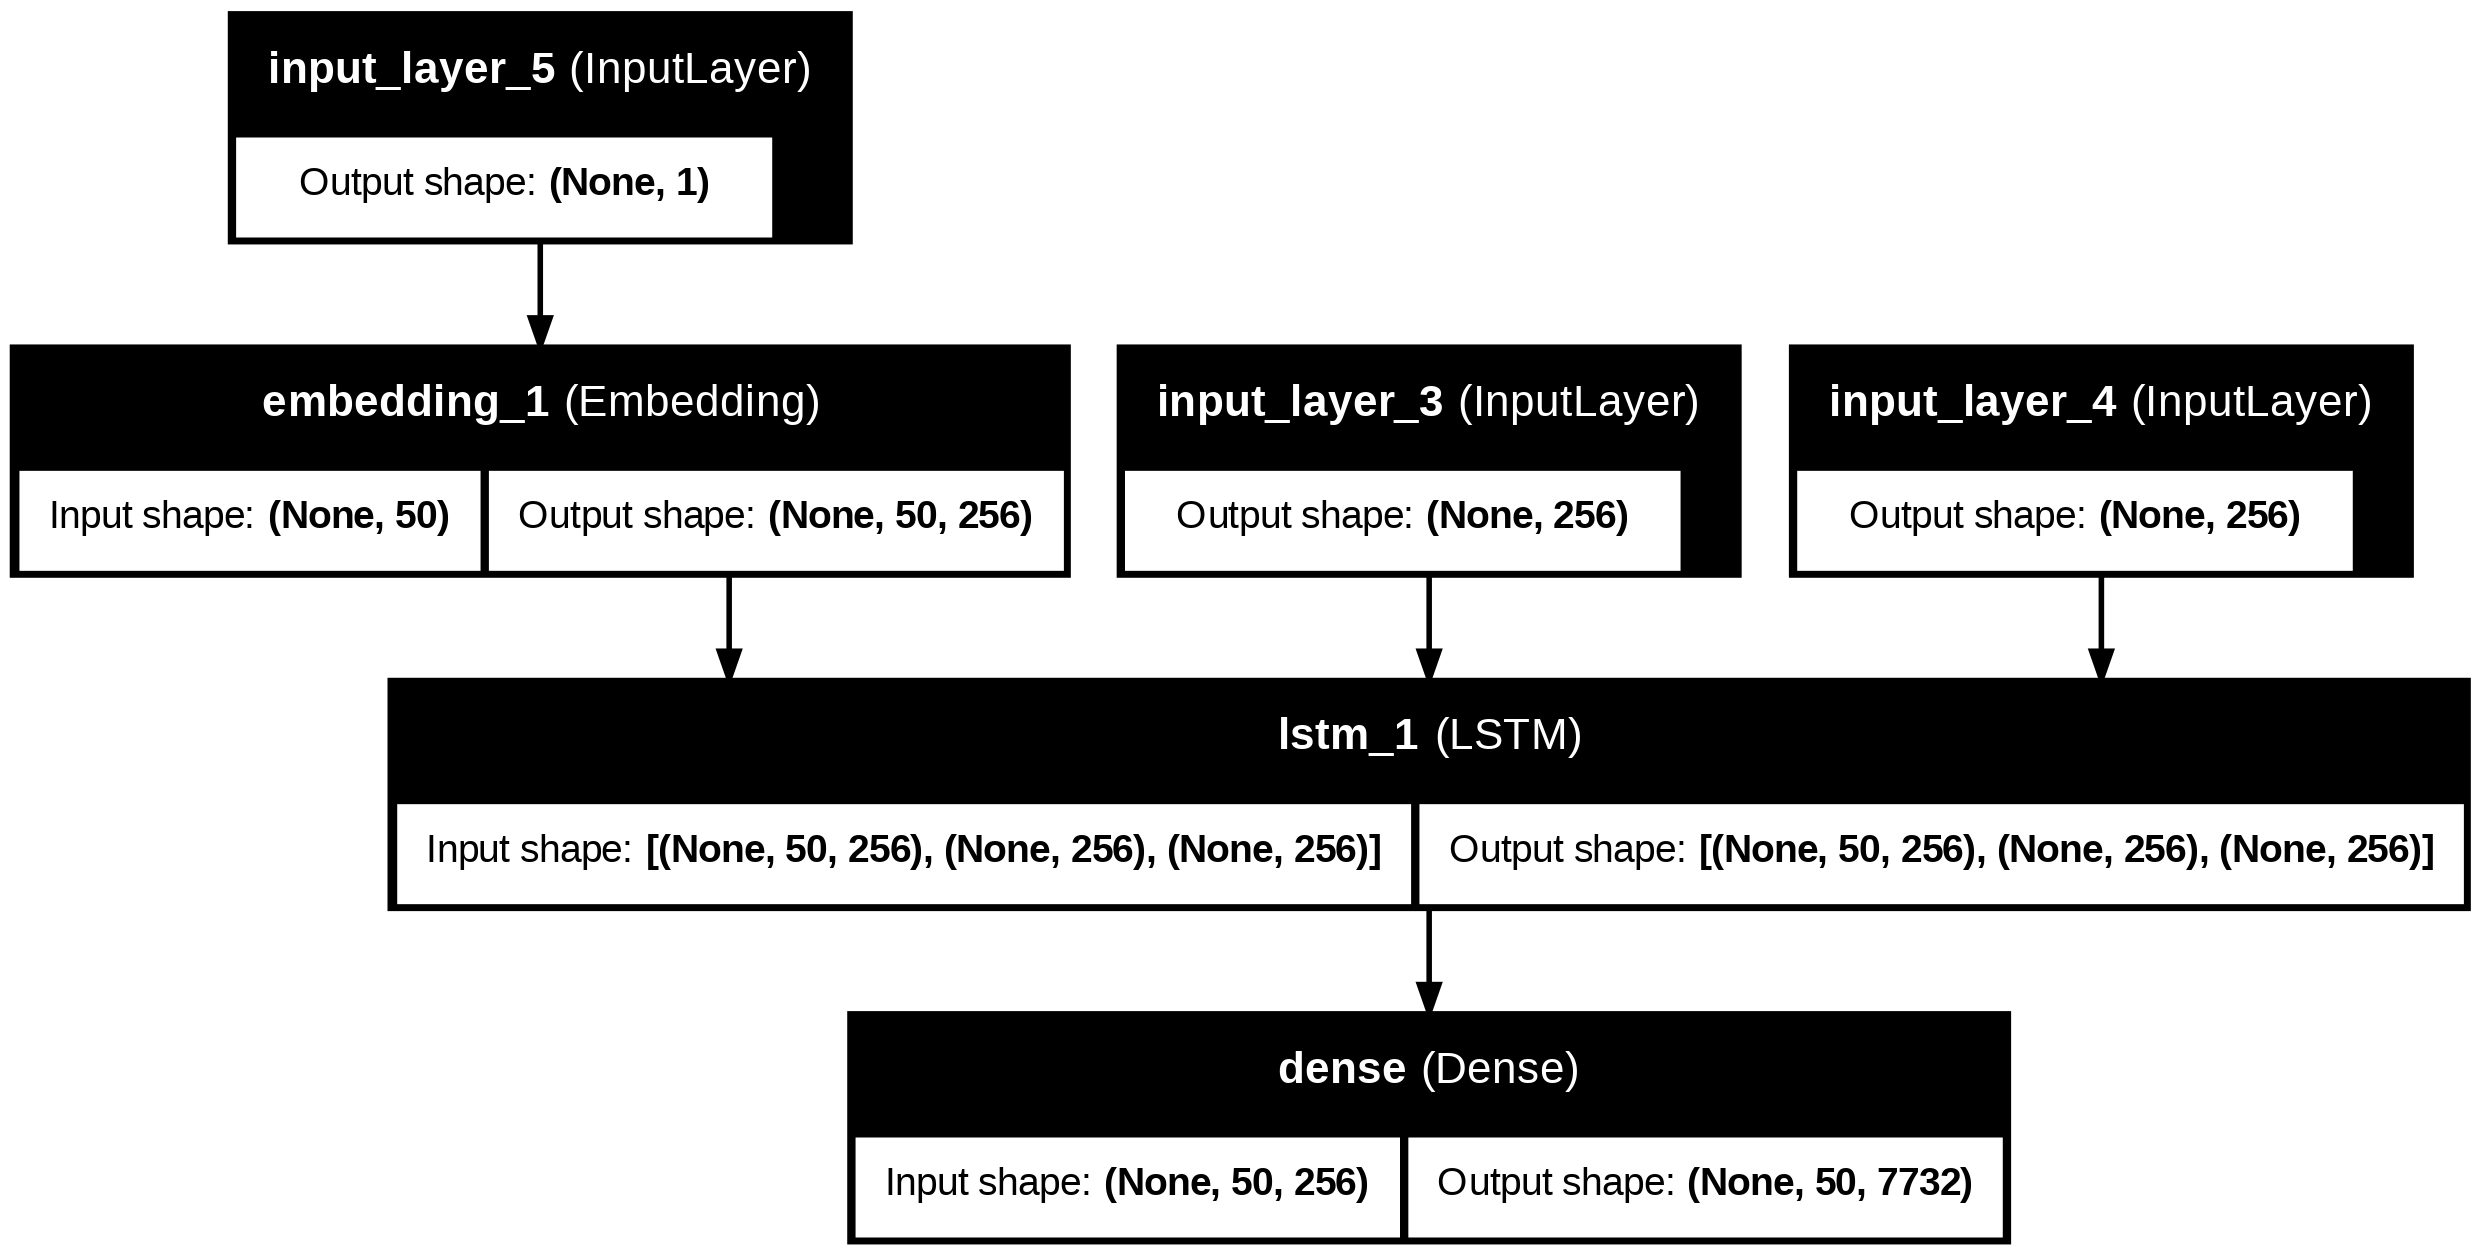

In [22]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 184ms/step - accuracy: 0.8431 - loss: 2.2379 - val_accuracy: 0.8816 - val_loss: 0.8433
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8819 - loss: 0.8204 - val_accuracy: 0.8839 - val_loss: 0.8148
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8848 - loss: 0.7784 - val_accuracy: 0.8871 - val_loss: 0.7942
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8878 - loss: 0.7398 - val_accuracy: 0.8899 - val_loss: 0.7651
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8912 - loss: 0.6944 - val_accuracy: 0.8922 - val_loss: 0.7395
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8945 - loss: 0.6530 - val_accuracy: 0.8942 - val_loss: 0.7217
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8973 - loss: 0.6152 - val_accuracy: 0.8957 - val_loss: 0.7097
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9001 - loss: 0

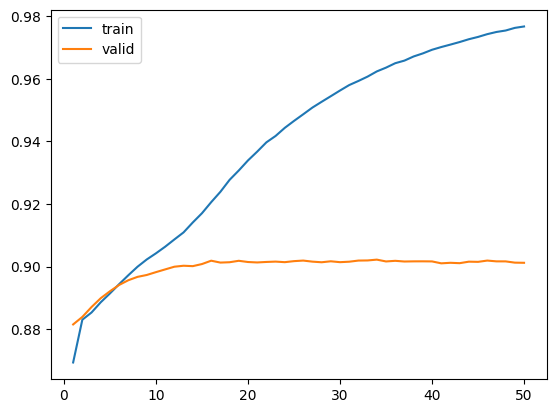

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [25]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [26]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [27]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [28]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
-
Input: Mary wants to buy a dress.
Response: mary quiere comprar un vestido


In [29]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [16, 240, 129]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0  16 240 129]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Response: me duele la pierna


In [30]:
input_test = "My brother works in a hospital."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My brother works in a hospital.
Representacion en vector de tokens de ids [16, 278, 759, 9, 6, 445]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  16 278 759   9   6 445]]
Input: My brother works in a hospital.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Response: mi casa tiene una mujer grande


## **Resultados de pruebas**

A continuación, se explican las pruebas realizadas sobre la notebook:

Las primeras pruebas se hicieron modificando sólamente los siguientes parámetros: MAX_NUM_SENTENCES, MAX_VOCAB_SIZE, max_input_len, max_out_len, n_units.

Todas las pruebas realizadas se hicieron durante 50 épocas.
Por limitaciones de la RAM disponible en Google Colab, el máximo número para MAX_NUM_SENTENCES fue de 10000.

A continuación, se adjuntan los valores usados en cada pruebas, y los gráficos y resultados obtenidos.





### ***Prueba 1***

MAX_NUM_SENTENCES 8000 ,MAX_VOCAB_SIZE = 9000 max_input_len = 24
max_out_len = 32

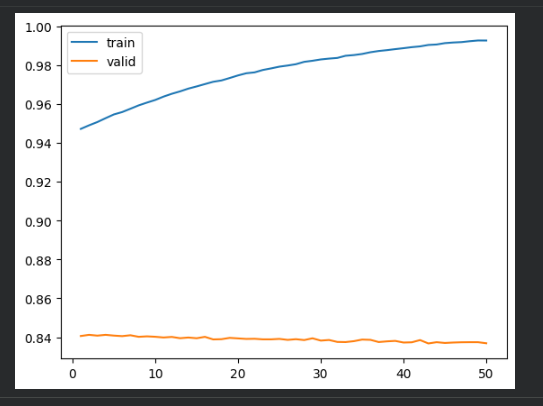



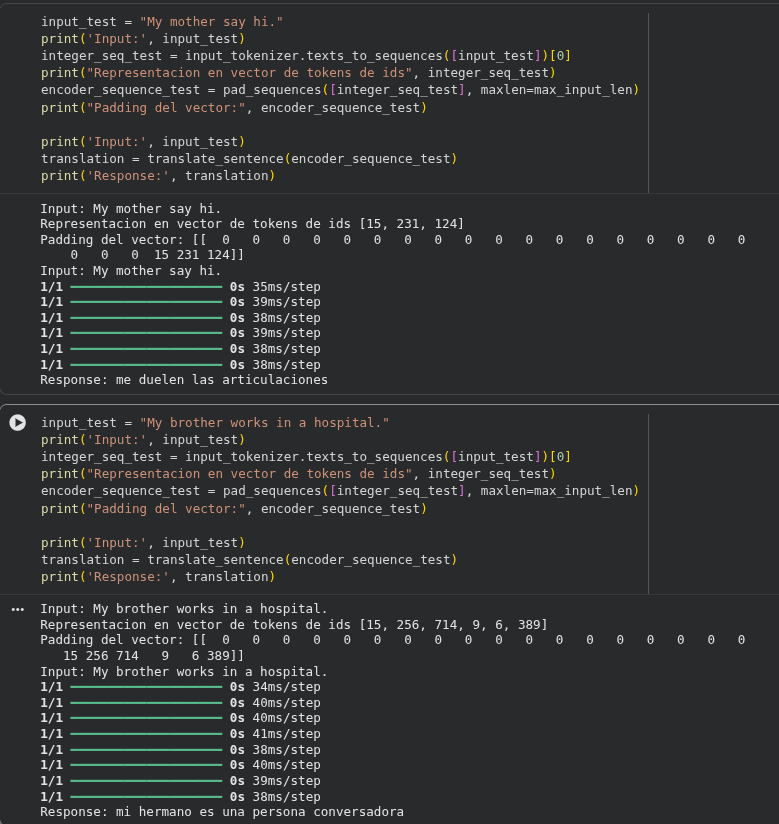





Con esta primera prueba se logró que las oraciones generadas sea coherentes aunque no son la traducción exacta de la frase original. Esto se logró aumentado la cantidad máxima de frases ausar del dataset, el tamaño máximo del vocabulario,número máximo de tokens que una frase de entrada puede tener y el número máximo de tokens que una frase de salida puede tener.

### ***Prueba 2***

MAX_NUM_SENTENCES = 10000, MAX_VOCAB_SIZE = 9000, max_input_len = 36
max_out_len = 44

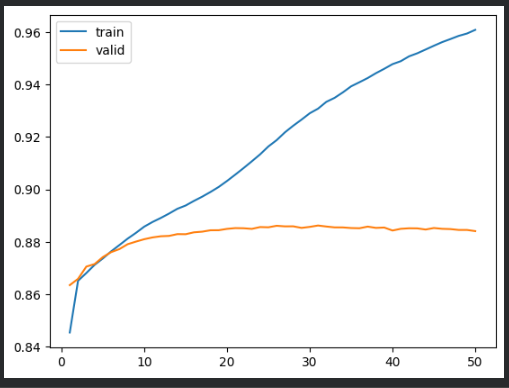


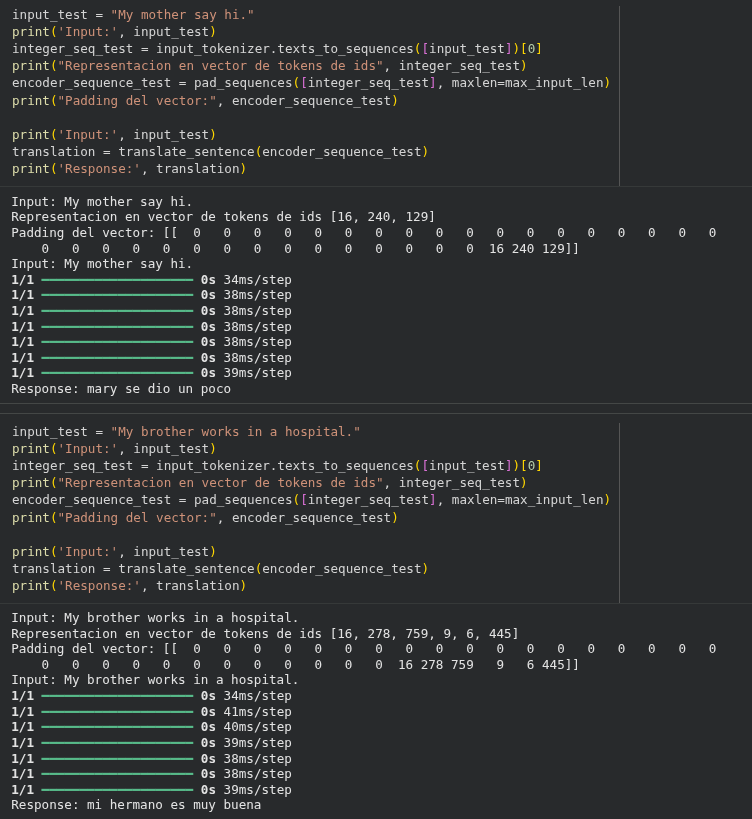

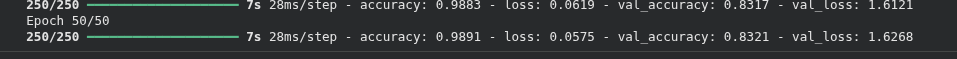

En este caso se aumento el MAX_NUM_SENTENCES y la longitud de las frases de entrada y salida, pero en este caso se obtuvieron frases cortadas.

### ***Prueba 3***

MAX_NUM_SENTENCES = 10000,MAX_VOCAB_SIZE = 8000,max_input_len = 30
max_out_len = 30,n_units = 256


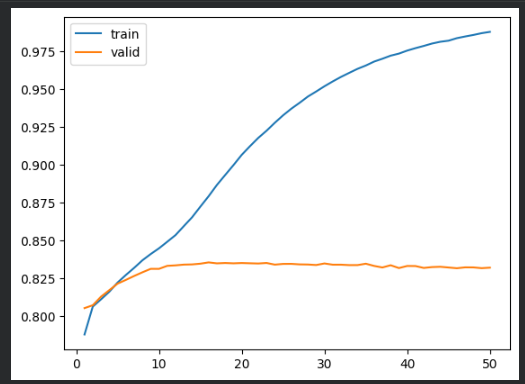

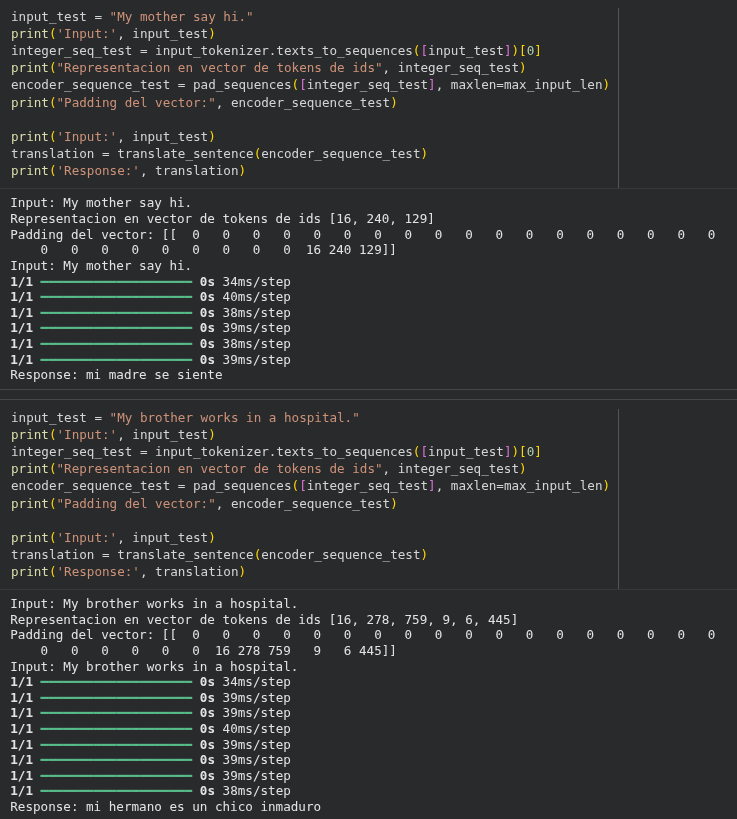


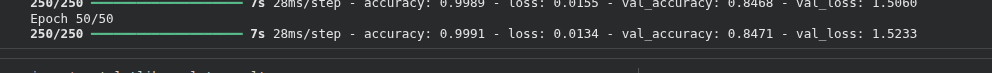

En este caso, el principal cambio es el del tamaño de la memoria interna de la LSTM que subió a 256. Con esto, en el segundo caso, se obtuvo una frase completa y coherente.

### ***Prueba 4***

Tambien se hicieron pruebas modificando la estructura del enconder de la siguiente manera:

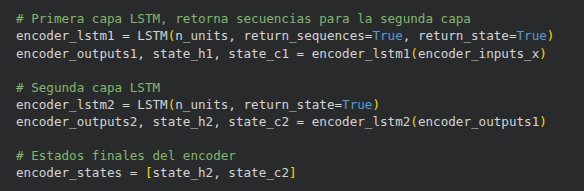

MAX_NUM_SENTENCES = 10000,MAX_VOCAB_SIZE = 8000,max_input_len = 30
max_out_len = 30,n_units = 256

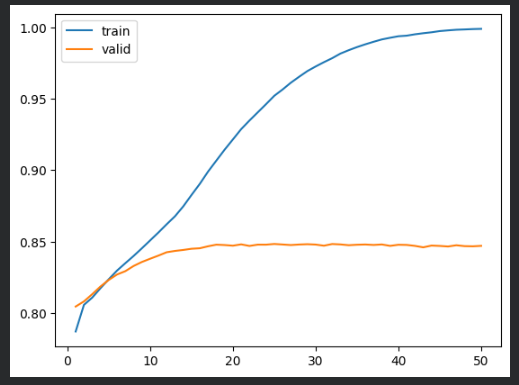

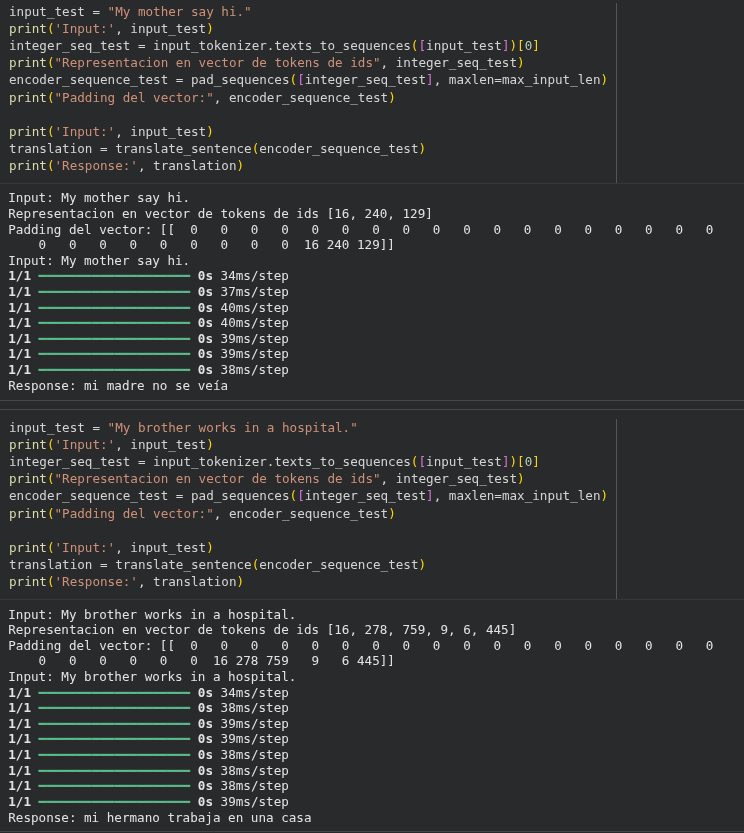


Con este cambio, se logró que en el segundo caso, que se trata de una frase más compleja, obtener una frase completa, coherente y además muy cercana a la traducción real.

### ***Prueba 5***

Tambien se realizaron pruebas poniéndole tanto al encoder como al decoder un dropout y un recurrent dropout:

MAX_NUM_SENTENCES = 10000,MAX_VOCAB_SIZE = 8000,max_input_len = 50
max_out_len = 50,n_units = 256

- encoder = LSTM(n_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)

- decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)

Ademas se aumento el max input y out lenght


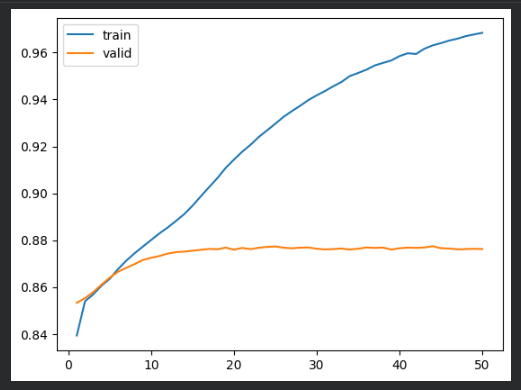


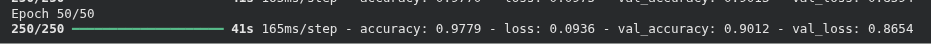


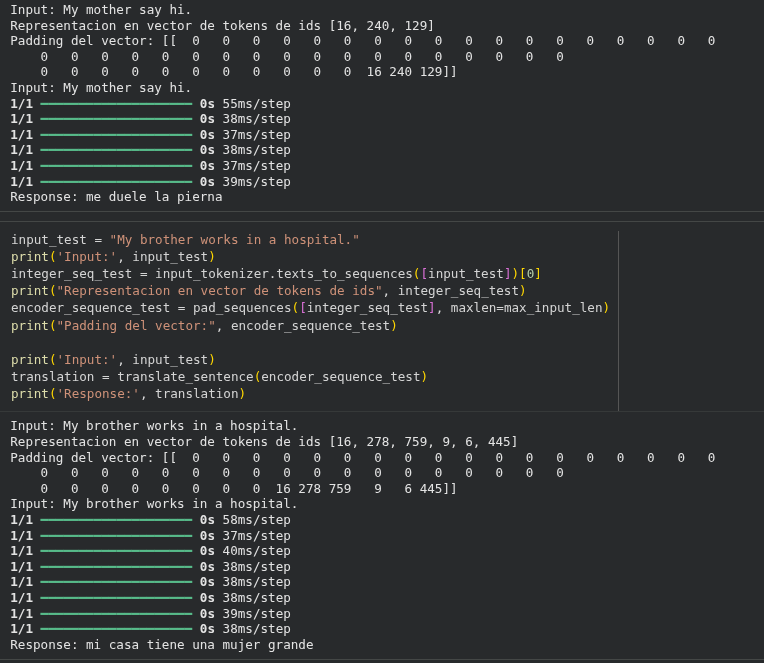

En este caso se logró tener un mayor accurracy. Ambas traducciones estan alejadas de la traducción real pero se obtuvieron frases completas y coherentes.

El caso en el que se logró un mejor resultado en cuanto a traducción, fue cuando se modificó la estructura del encoder, poniendo 2 capas LSTM que lograron, en el segundo ejemplo, obtener una traducción más precisa.

Otro caso en que se obtuvieron buenos resultados en cuanto a coherencia de las frases fue en la última prueba donde se aumentó el max input,output y se pusieron dropouts. Esto ayudó a que se obtuvieran frases completas y coherentes en ambos casos. Pero muy alejados de la traducción real.